In [1]:
from IPython.display import HTML
HTML('''<style>html, body{overflow-y: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides

# Foundations of Data Mining: Assignment 1

Please complete all assignments in this notebook. You should submit this notebook, as well as a PDF version (See File > Download as).

In [1]:
# Please fill in your names here
NAME_STUDENT_1 = "Ylja Remmits"
NAME_STUDENT_2 = "Wout de Ruiter"

In [2]:
%matplotlib inline
from preamble import *
plt.rcParams['savefig.dpi'] = 100 # This controls the size of your figures
# Comment out and restart notebook if you only want the last output of each cell.
# InteractiveShell.ast_node_interactivity = "all"

## MoneyBall (5 points, 1+2+1+1)
In the early 2000s, 2 baseball scouts completely changed the game of baseball by analysing the available data about baseball players and hiring the best ones.
The [MoneyBall dataset](https://www.openml.org/d/41021) contains this data (click the link for more details). The goal is to accurately predict the number of 'runs' each player can score. 

In [3]:
moneyball = oml.datasets.get_dataset(41021) # Download MoneyBall data
# Get the predictors X and the target y
X, y, attribute_names = moneyball.get_data(target=moneyball.default_target_attribute, return_attribute_names=True)
# Describe the data with pandas, just to get an overview
ballframe = pd.DataFrame(X, columns=attribute_names)
ballframe_vis = ballframe.copy()
ballframe_vis['target'] = y
ballframe.describe()

Team  League     Year       RA   ...    RankPlayoffs        G  \
count  1232.00  1232.0  1232.00  1232.00   ...          244.00  1232.00   
mean     15.67     0.5  1988.96   715.08   ...            1.72     3.92   
std       9.72     0.5    14.82    93.08   ...            1.10     0.62   
min       0.00     0.0  1962.00   472.00   ...            0.00     0.00   
25%       7.00     0.0  1976.75   649.75   ...            1.00     4.00   
50%      16.00     0.5  1989.00   709.00   ...            2.00     4.00   
75%      23.00     1.0  2002.00   774.25   ...            3.00     4.00   
max      38.00     1.0  2012.00  1103.00   ...            4.00     7.00   

         OOBP    OSLG  
count  420.00  420.00  
mean     0.33    0.42  
std      0.02    0.03  
min      0.29    0.35  
25%      0.32    0.40  
50%      0.33    0.42  
75%      0.34    0.44  
max      0.38    0.50  

[8 rows x 14 columns]

1 . Visually explore the data. Plot the distribution of each feature (e.g. histograms), as well as the target. Visualize the dependency of the target on each feature (use a 2d scatter plot). Is there anything that stands out? Is there something that you think might require special treatment?
- Feel free to create additional plots that help you understand the data
- Only visualize the data, you don't need to change it (yet)

Team           -0.11
League         -0.19
Year            0.42
RA              0.38
W               0.51
OBP             0.90
SLG             0.92
BA              0.83
Playoffs        0.39
RankSeason     -0.03
RankPlayoffs    0.21
G               0.08
OOBP            0.13
OSLG            0.19
target          1.00
Name: target, dtype: float64


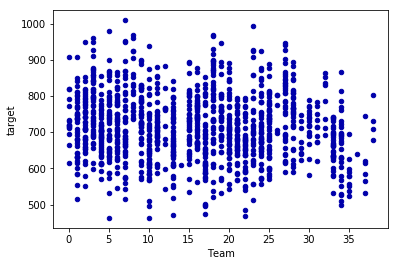

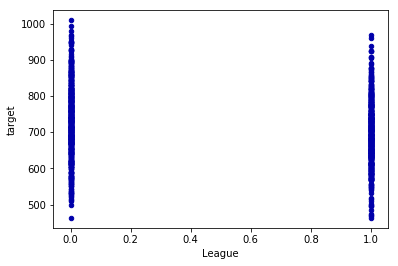

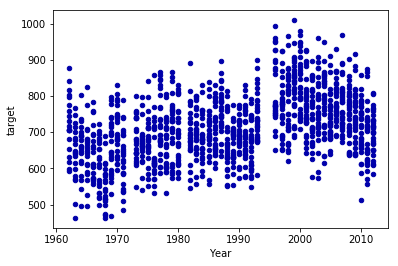

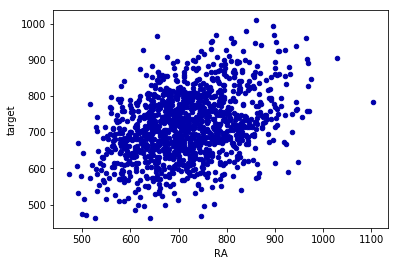

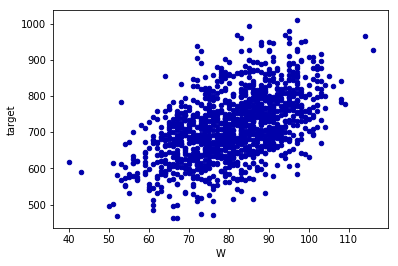

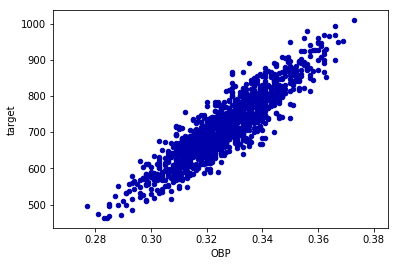

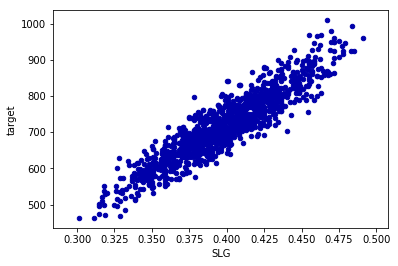

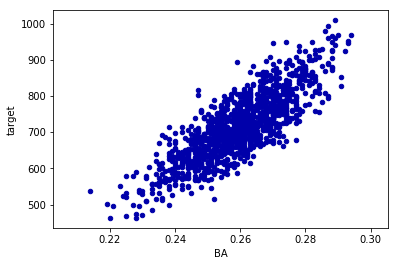

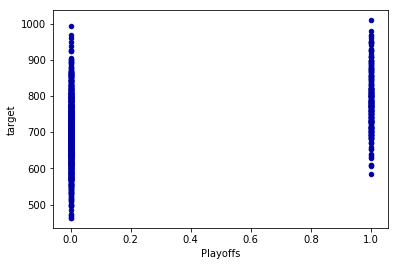

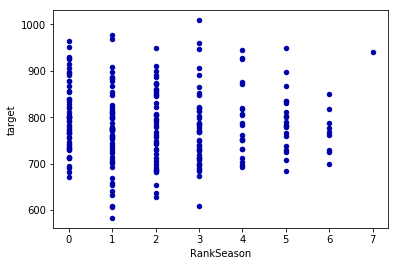

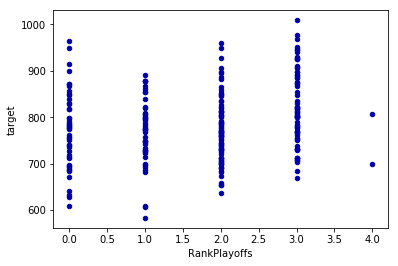

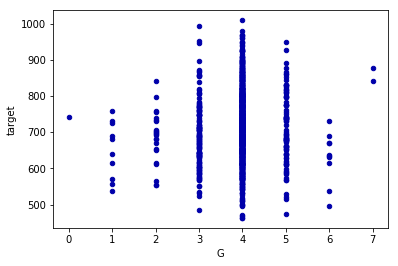

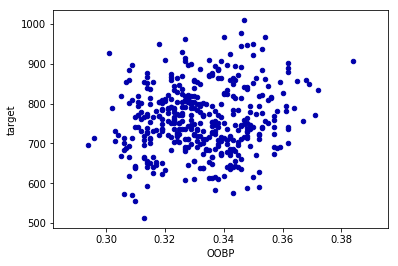

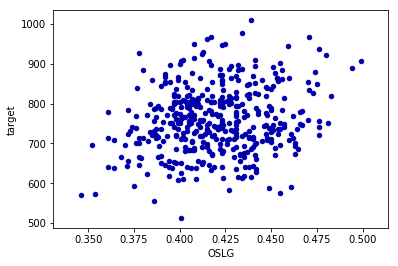

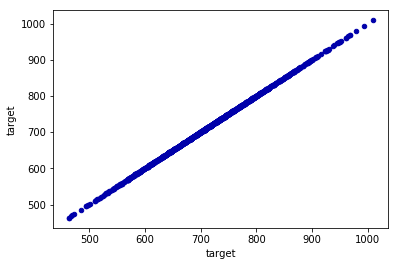

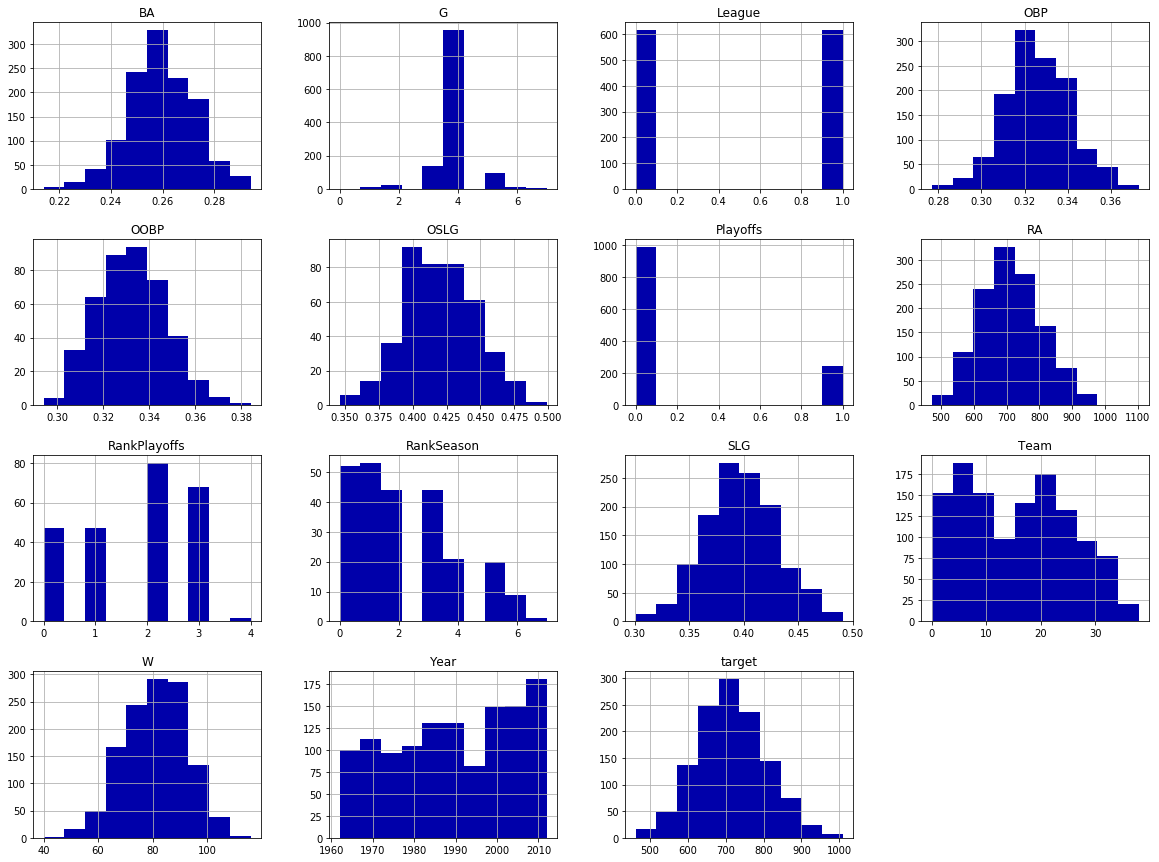

In [11]:
for feature in ballframe_vis.columns:
    ballframe_vis.plot(x=feature, y="target", kind="scatter")
ballframe_vis.hist(figsize=(20,15))
print(ballframe_vis.corr()["target"]);

2 . Compare all linear regression algorithms that we covered in class (Linear Regression, Ridge, Lasso and ElasticNet), as well as kNN. Evaluate using cross-validation and the $R^2$ score, with the default parameters. Does scaling the data with StandardScaler help? Provide a concise but meaningful interpretation of the results.
- Preprocess the data as needed (e.g. are there nominal features that are not ordinal?). If you don't know how to proceed, remove the feature and continue.

# Motivation of preprocessing:

'Team' is a nomimal feature that is not ordinal. We replace 'Team' with dummy features.  Upon visual inspection we find that 'Year' and 'G' (the number of games played) might not have a linear relation to the target. Therefore we add polynomial features (up to a degree of 3) for these two features. We did not add interaction features.

For four features most data(more than 65% of points) is missing: 'RankSeason', 'RankPlayoffs', 'OOBP', 'OSLG'. We decided to remove these features.



In [4]:
# preprocessing
from sklearn.preprocessing import PolynomialFeatures

#add dummies
# ballframe_wdummies = pd.get_dummies(ballframe, columns=['Team'])
#add polynomial features, no interaction features
poly = PolynomialFeatures(degree=3, include_bias=False)
df_p = pd.DataFrame(poly.fit_transform(ballframe[['Year', 'G']]), columns=['Year', 'G', 'Year^2', 'YearxG', 'G^2', 'Year^3', 'Year^2xG', 'YearxG^2', 'G^3'])
df_poly = df_p[['Year^2', 'G^2', 'Year^3', 'G^3']]
x_complete = pd.concat([ballframe, df_poly], axis=1)

In [5]:
totlen = len(x_complete)
print('Total nr of datapoints: {}'.format(totlen))
print('nr nan for rank season: {}, missing {}%'.format(x_complete['RankSeason'].isna().sum(), x_complete['RankSeason'].isna().sum()/totlen*100))
print('nr nan for rank playoffs: {}, missing {}%'.format(x_complete['RankPlayoffs'].isna().sum(), x_complete['RankPlayoffs'].isna().sum()/totlen*100))
print('nr nan for rank oobp: {}, missing {}%'.format(x_complete['OOBP'].isna().sum(), x_complete['OOBP'].isna().sum()/totlen*100))
print('nr nan for rank oslg: {}, missing {}%'.format(x_complete['OSLG'].isna().sum(), x_complete['OSLG'].isna().sum()/totlen*100))
x_complete = x_complete.drop(columns=['RankSeason', 'RankPlayoffs', 'OOBP', 'OSLG', 'Team'])
x_complete.head()

Total nr of datapoints: 1232
nr nan for rank season: 988, missing 80.1948051948052%
nr nan for rank playoffs: 988, missing 80.1948051948052%
nr nan for rank oobp: 812, missing 65.9090909090909%
nr nan for rank oslg: 812, missing 65.9090909090909%


League    Year     RA     W  ...     Year^2   G^2    Year^3   G^3
0     1.0  2012.0  688.0  81.0  ...   4.05e+06  16.0  8.14e+09  64.0
1     1.0  2012.0  600.0  94.0  ...   4.05e+06  16.0  8.14e+09  64.0
2     0.0  2012.0  705.0  93.0  ...   4.05e+06  16.0  8.14e+09  64.0
3     0.0  2012.0  806.0  69.0  ...   4.05e+06  16.0  8.14e+09  64.0
4     1.0  2012.0  759.0  61.0  ...   4.05e+06  16.0  8.14e+09  64.0

[5 rows x 13 columns]

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import ShuffleSplit


#define test methods and features
# x_complete = ballframe[["OBP", "SLG", "BA"]];
testMethods = [["linear regression", linear_model.LinearRegression()],
               ["Ridge", Ridge()],
               ["lasso", Lasso()],
               ["nearest neighbours", KNeighborsRegressor()],
               ["Elastic Net", ElasticNet()]];

# folds
from sklearn.model_selection import KFold
kfold = KFold(shuffle=True)



#define datasets
# x_train, x_test, y_train, y_test = train_test_split(x_complete, y);


#do testing
for method in testMethods:
    print(method[0])
    method = method[1]
    pipe = make_pipeline(StandardScaler(), method)
    scores_scaled = cross_val_score(pipe, x_complete, y, cv=kfold)
#     pipe.fit(x_train, y_train)
    scores = cross_val_score(method, x_complete, y, cv=kfold)
#     method.fit()
#     print("With Scaling  - R2 Score : {:.2f}".format(pipe.score(x_test, y_test)));    
    print("With Scaling  - Cross-validation scores: {}".format(scores_scaled));
#     print("No Scaling  - R2 Score : {:.2f}".format(pipe.score(x_test, y_test)));    
    print("No Scaling  - Cross-validation scores: {}\n".format(scores));



linear regression
With Scaling  - Cross-validation scores: [0.948 0.949 0.944]
No Scaling  - Cross-validation scores: [0.947 0.948 0.945]

Ridge
With Scaling  - Cross-validation scores: [0.95  0.949 0.942]
No Scaling  - Cross-validation scores: [0.891 0.873 0.879]

lasso
With Scaling  - Cross-validation scores: [0.955 0.936 0.945]
No Scaling  - Cross-validation scores: [0.85  0.842 0.875]

nearest neighbours
With Scaling  - Cross-validation scores: [0.867 0.868 0.866]
No Scaling  - Cross-validation scores: [0.207 0.292 0.34 ]

Elastic Net
With Scaling  - Cross-validation scores: [0.912 0.914 0.891]
No Scaling  - Cross-validation scores: [0.856 0.86  0.857]



3 . Do a default, shuffled train-test split and optimize the linear models for the degree of regularization ($alpha$) and choice of penalty (L1/L2). For Ridge and  Lasso, plot a curve showing the effect of the training and test set performance ($R^2$) while increasing the degree of regularization for different penalties. For ElasticNet, plot a heatmap $alpha \times l1\_ratio \rightarrow R^2$ using test set performance.
Report the optimal performance. Again, provide a concise but meaningful interpretation. What does the regularization do? Can you get better results?
- Think about how you get the L1/L2 loss. This is not a hyperparameter in regression.
- We've seen how to generate such heatmaps in Lecture 3.

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x_complete, y, random_state=1232156);

scaler = MinMaxScaler()
scaler.fit(x_train)
X_train_scaled = scaler.transform(x_train)
X_test_scaled = scaler.transform(x_test)

# x_transformed_train = scaler.transform(x_train);
# x_transformed_test = scaler.transform(x_test);
# x_transformed_complete = scaler.transform(x_complete);

testMethods = [["Lasso", Lasso()], #L1 error
               ["Ridge", Ridge()], #L2 error               
               ["Elastic Net", ElasticNet()]]; #super combi deal

l1l2Coefficient = [[-1], [-1], [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]]

# datasets = [["normal training set", x_train, y_train], 
#            ["transformed training set", x_transformed_train, y_train],
#            ["normal test set", x_test, y_test, x_complete, y],
#            ["transformed test set", x_transformed_test, y_test, x_transformed_complete, y]];

alphas = np.logspace(0, 1, 20)/10
print (alphas)

#do testing
results = []
for i, method in enumerate(testMethods):
    print(method[0])
    method = method[1]
    resultsMethod = []
    coefficients = l1l2Coefficient[i]
    pipe = make_pipeline(StandardScaler(), method)
    for a in alphas:
        score = []
        for coef in coefficients:
            if coef>=0: 
               method.set_params(l1_ratio=coef);            
            method.set_params(alpha=a);
            method.fit(X_train_scaled, y_train);
            if coef>=0: 
                score.append(method.score(X_test_scaled, y_test))
#                  print(method.score(X=x_test, y=y_test))
            else:
                score = (method.score(X_train_scaled, y_train), method.score(X_test_scaled, y_test));
#                 print(score)
        resultsMethod.append(score);
    results.append(resultsMethod);
    

[0.1   0.113 0.127 0.144 0.162 0.183 0.207 0.234 0.264 0.298 0.336 0.379
 0.428 0.483 0.546 0.616 0.695 0.785 0.886 1.   ]
Lasso
Ridge
Elastic Net


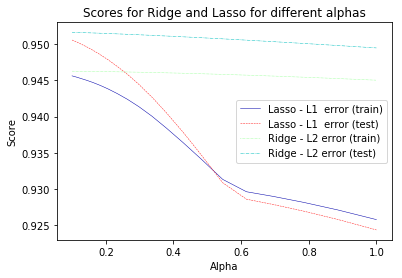

In [8]:
#graph of lasso en ridge
lassoResults_train = [train for train, _ in results[0]]
lassoResults_test = [test for _, test in results[0]]
ridgeResults_train = [train for train, _ in results[1]]
ridgeResults_test = [test for _, test in results[1]]
import matplotlib.pyplot as plt
plt.plot(alphas, lassoResults_train);
plt.plot(alphas, lassoResults_test);
plt.plot(alphas, ridgeResults_train);
plt.plot(alphas, ridgeResults_test);
plt.xlabel('Alpha')
plt.ylabel('Score')
plt.legend(['Lasso - L1  error (train)', 'Lasso - L1  error (test)', 'Ridge - L2 error (train)', 'Ridge - L2 error (test)'], loc='center right')
plt.title('Scores for Ridge and Lasso for different alphas')
plt.show();

In [9]:
elasticNetResults = pd.DataFrame(results[2], columns=coefficients, index=alphas)
# for (a, coef, score) in [item for sublist in results[2] for item in sublist]:
#     lassoResults[str(a)][str(coef)] = score
elasticNetResults.head(10)

0.1   0.2   0.3   0.4  ...    0.7   0.8   0.9   1.0
0.10  0.69  0.71  0.74  0.76  ...   0.85  0.88  0.92  0.95
0.11  0.67  0.69  0.72  0.74  ...   0.84  0.87  0.91  0.95
0.13  0.65  0.67  0.69  0.72  ...   0.82  0.86  0.91  0.95
0.14  0.62  0.64  0.67  0.70  ...   0.81  0.85  0.90  0.95
0.16  0.60  0.62  0.65  0.68  ...   0.79  0.84  0.89  0.95
0.18  0.57  0.60  0.62  0.65  ...   0.77  0.83  0.89  0.95
0.21  0.55  0.57  0.60  0.63  ...   0.75  0.81  0.88  0.95
0.23  0.52  0.54  0.57  0.60  ...   0.73  0.79  0.87  0.95
0.26  0.49  0.52  0.55  0.58  ...   0.71  0.77  0.86  0.95
0.30  0.47  0.49  0.52  0.55  ...   0.69  0.76  0.84  0.94

[10 rows x 10 columns]

(20, 10)


Text(70,0.5,'Alpha')

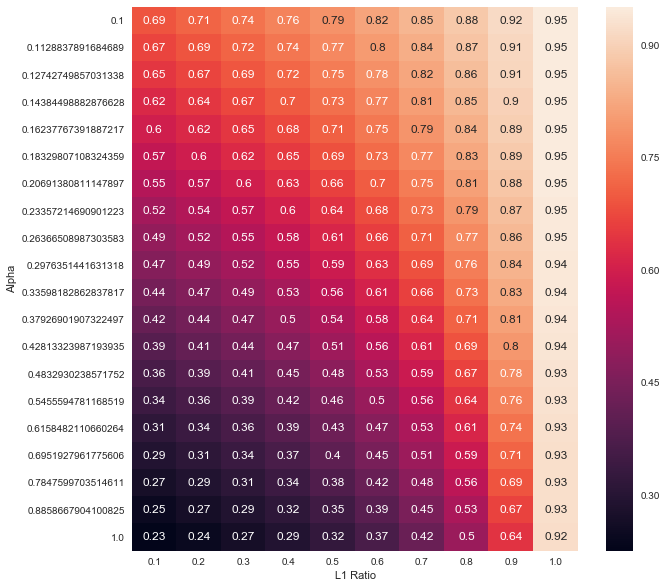

In [10]:
#Make the heatmap

import seaborn as sns; sns.set()
from matplotlib import pyplot
# elasticNetResults = np.array(results[2])
print(elasticNetResults.shape)
fig, ax = pyplot.subplots(figsize=(10,10))
ax = sns.heatmap(elasticNetResults, annot=True)
ax.set_xlabel('L1 Ratio')
ax.set_ylabel('Alpha')
# mglearn.tools.heatmap(elasticNetResults, xticklabels=elasticNetResults.columns, xlabel='L1 Ratio', ylabel='Alpha', yticklabels=elasticNetResults.index)




4 . Visualize the coefficients of the optimized models. Do they agree on which features are
important? Compare the results with the feature importances returned by a RandomForest. Does it agree with the linear models? What would look for when scouting for a baseball player?

('RA', 'W', 'OBP', 'SLG')

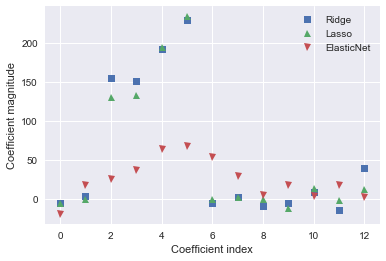

In [11]:
# visualise optimized results
ridge = Ridge(alpha=0.1)
lasso = Lasso(alpha=0.1)
elastic = ElasticNet(alpha=0.1, l1_ratio=0)
ridge.fit(X_train_scaled, y_train)
lasso.fit(X_train_scaled, y_train)
elastic.fit(X_train_scaled, y_train)

plt.plot(ridge.coef_, 's', label="Ridge")
plt.plot(lasso.coef_, '^', label="Lasso")
plt.plot(elastic.coef_, 'v', label="ElasticNet")

plt.xlabel("Coefficient index")
plt.ylabel("Coefficient magnitude")
# plt.hlines(0, 0, len(lr.coef_))
# plt.ylim(-25, 25)
plt.legend()

x_complete.columns[2], x_complete.columns[3], x_complete.columns[4], x_complete.columns[5]

(-1, 13)

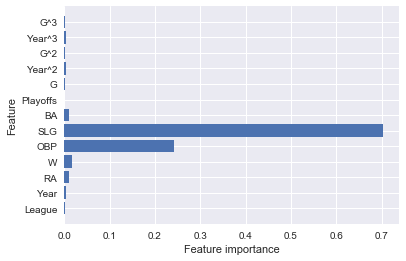

In [12]:
#random forrest
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(random_state=2)
forest.fit(X_train_scaled, y_train) 


n_features = len(x_complete.columns)
plt.barh(range(n_features), forest.feature_importances_, align='center')
plt.yticks(np.arange(n_features), x_complete.columns)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.ylim(-1, n_features)


In [21]:
x_complete.columns[2], x_complete.columns[3], x_complete.columns[4], x_complete.columns[5]

('RA', 'W', 'OBP', 'SLG')

## Nepalese character recognition (5 points, 1+2+2)
The [Devnagari-Script dataset](https://www.openml.org/d/40923) contains 92,000 images (32x32 pixels) of 46 characters from Devanagari script. Your goal is to learn to recognize the right letter given the image.

In [13]:
devnagari = oml.datasets.get_dataset(40923) # Download Devnagari data
# Get the predictors X and the labels y
X, y = devnagari.get_data(target=devnagari.default_target_attribute); 
#classes = devnagari.retrieve_class_labels(target_name='character') # This one takes a while, skip if not needed

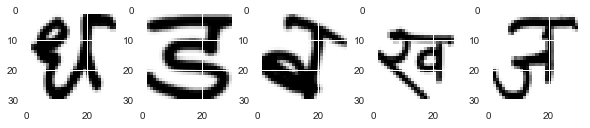

In [14]:
from random import randint
# Take some random examples, reshape to a 32x32 image and plot
fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
for i in range(5):
    n = randint(0,90000)
    axes[i].imshow(X[n].reshape(32, 32), cmap=plt.cm.gray_r)
    #axes[i].set_xlabel("Class: %s" % (classes[y[n]]))
plt.show();

1. Evaluate k-Nearest Neighbors, Logistic Regression and RandomForests with their default settings.
    - Take a stratified 10% subsample of the data.
    - Use the default train-test split and predictive accuracy. Is predictive accuracy a good scoring measure for this problem?
    - Try to build the same models on increasingly large samples of the dataset (e.g. 10%, 20%,...). Plot the training time and the predictive performance for each. Stop when the training time becomes prohibitively large (this will be different for different models). 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
import multiprocessing
import time

def calculateModel(method, x_train, x_test, y_train, y_test, chunking = False):
    startTime = time.time()
    method.fit(x_train, y_train)
    score = method.score(x_test, y_test);    
    totalTime = time.time() - startTime
    return score, totalTime


globalStartTime = time.time()
stop = False
trainingPercentage = 0.0
scores = []
stopModels = []

while(stop == False and trainingPercentage<0.7):
    
    testMethods = [["Logistic Regression", True, LogisticRegression(n_jobs=-1)],
               ["Nearest Neighbours", False, KNeighborsRegressor()],
               ["Random Forests", True, RandomForestRegressor(n_jobs=-1)]];

    
    trainingPercentage += 0.1
    failures = 0
    
    print("tranings percentage = " + str(trainingPercentage) )
    
    #Take the stratified subsamples
    X_used = X
    y_used = y
    if trainingPercentage != 1:
        X_used, _, y_used, _ = train_test_split(X, y,  test_size=1-trainingPercentage, stratify=y)
    
    #define datasets
    x_train, x_test, y_train, y_test = train_test_split(X_used, y_used, random_state=456468, test_size=0.25);
    
    
    modelResults = []
    for i in range(len(testMethods)):
        startTime = time.time()
        stopTime = startTime + (1000 * 1000 * 60 * 20) #stop always after 20 minutes of calculation
        if i in stopModels:
            modelResults.append([0,-1])
        else:
            print("doing testMethod ", i)
            modelResults.append(calculateModel(testMethods[i][2], x_train, x_test, y_train, y_test, testMethods[i][1]))
            if(time.time()>stopTime):
                stopModels.append(i)
            
    scores.append(modelResults)
    if(len(stopModels)>2):
        stop = True
    
    #MULTIPROCESSING DOES NOT WORK IN JUPYTER NOTEBOOK
    #startTime = time.time()
    #stopTime = startTime + (1000 * 1000 * 60 * 20) #stop always after 20 minutes of calculation
    
    
    #manager = multiprocessing.Manager()
    #returnDict = manager.dict()
    #jobs = []
    #for i in range(len(testMethods)):
        #p = multiprocessing.Process(target=calculateModel, args=(i, testMethods[i], x_train, x_test, y_train, y_test, returnDict))
        #jobs.append(p)
        #p.start()
        #print("start job " + str(i) + " with pid " + p.pid)
    
    #for i in range(len(testMethods)):
        #print("joining processses" + str((stopTime-time.time())/1000/1000))
        #if (stopTime-time.time()) > 1000 * 1000 * 10: #if more than 10 seconds are left
            #jobs[i].join((stopTime-time.time())/1000/1000)
        
        #if jobs[i].is_alive():
            #print("terminating")
            #jobs[i].terminate()
            #jobs[i].join()
            
            #returnDict[procnum] = [0, -1]
            
            #failures += 1
            #print("testmethod " + testMethods[i][0] + "aborted after " 
            #+ str((time.time() - startTime)/1000.0/1000.0/60.0) + " minutes with trainingspercentage " + trainingPercentage)

    #if failures>len(testMethods)-1:
        #stop = True
        
    
    

globalStopTime = time.time()                   
print(scores[0])


tranings percentage = 0.1
doing testMethod  0
doing testMethod  1
doing testMethod  2
tranings percentage = 0.2
doing testMethod  0
doing testMethod  1


2 . Optimize the value for the number of neighbors $k$ (keep $k$ < 50) and the number of trees (keep $n\_estimators$ < 100) on the stratified 10% subsample.
- Use 10-fold crossvalidation and plot $k$ and $n\_estimators$ against the predictive accuracy. Which value of $k$, $n\_estimators$ should you pick?

In [ ]:
import matplotlib.pyplot as plt

rawResults = ?

x_labels = parameters['n_estimators']

resultsTrain = []
for i in range(10):
    name = "split"+i+ "_train_score"
    resultsTrain.append(rawResults[name])

resultsTest = []
for i in range(10):
    name = "split"+i+ "_test_score"
    resultsTest.append(rawResults[name])

plt.plot(x_labels, results_train);
plt.plot(x_labels, results_test);
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.legend(['tranings score', 'test score'], loc='center right')
plt.show();




3 . For the RandomForest, optimize both $n\_estimators$ and $max\_features$ at the same time on the entire dataset.
- Use a nested cross-validation and a random search over the possible values, and measure the accuracy. Explore how fine-grained this random search can be, given your computational resources. What is the optimal performance you find?
- Hint: choose a nested cross-validation that is feasible. Don't use too many folds in the outer loop.
- Repeat the grid search and visualize the results as a plot (heatmap) $n\_estimators \times max\_features \rightarrow ACC$ with ACC visualized as the color of the data point. Try to make the grid as fine as possible. Interpret the results. Can you explain your observations? What did you learn about tuning RandomForests?

In [ ]:
import seaborn as sns; sns.set()
from matplotlib import pyplot
# elasticNetResults = np.array(results[2])
print(elasticNetResults.shape)
fig, ax = pyplot.subplots(figsize=(10,10))
ax = sns.heatmap(elasticNetResults, annot=True)
ax.set_xlabel('L1 Ratio')
ax.set_ylabel('Alpha')

## 3. Understanding Ensembles (5 points (3+2))
Do a deeper analysis of how RandomForests and Gradient Boosting reduce their prediction error. We'll use the MAGIC telescope dataset (http://www.openml.org/d/1120). When high-energy particles hit the atmosphere, they produce chain reactions of other particles called 'showers', and you need to detect whether these are caused by gamma rays or cosmic rays.

In [3]:
# Get the data
magic_data = oml.datasets.get_dataset(1120) # Download MAGIC Telescope data
X, y = magic_data.get_data(target=magic_data.default_target_attribute);

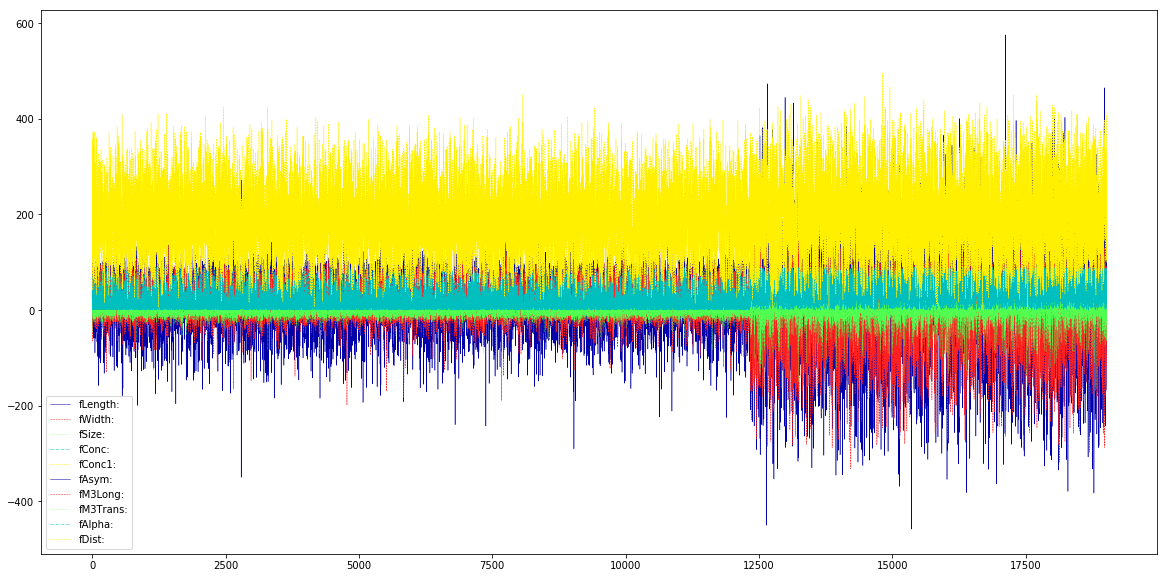

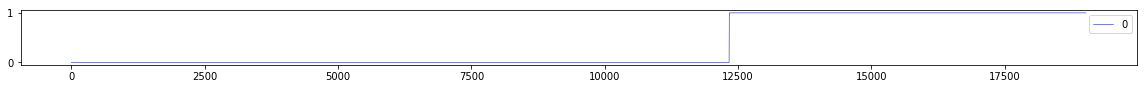

In [4]:
# Quick visualization
X, y, attribute_names = magic_data.get_data(target=magic_data.default_target_attribute, return_attribute_names=True)
magic = pd.DataFrame(X, columns=attribute_names)
magic.plot(figsize=(20,10))
# Also plot the target: 1 = gamma, 0 = background
pd.DataFrame(y).plot(figsize=(20,1));

1 . Do a bias-variance analysis of both algorithms. For each, vary the number of trees on a log scale from 1 to 1024, and plot the bias error (squared), variance, and total error (in one plot per algorithm). Interpret the results. Which error is highest for small ensembles, and which reduced most by each algorithm as you use a larger ensemble? When are both algorithms under- or overfitting? Provide a detailed explanation of why random forests and gradient boosting behave this way.
- See lecture 3 for an example on how to do the bias-variance decomposition
- To save time, you can use a 10% stratified subsample in your initial experiments, but show the plots for the full dataset in your report.

In [62]:
from sklearn.ensemble import RandomForestClassifier  
from sklearn.model_selection import ShuffleSplit

nrOfTrees = np.logspace(0,10, base=2)
nrOfTrees = np.ndarray.tolist(nrOfTrees.astype(int))
nrOfTrees = sorted(list(set(nrOfTrees)))
print(nrOfTrees)
n_repeat = 50
shuffle_split = ShuffleSplit(test_size=0.33, n_splits=n_repeat)
errors = []

# Store sample predictions


# Train classifier on each bootstrap and score predictions
for n in nrOfTrees:
    y_all_pred = [[] for _ in range(len(y))]
    for i, (train_index, test_index) in enumerate(shuffle_split.split(X)):
        # Train and predict
        forest = RandomForestClassifier(n_estimators=n, random_state=2)
        forest.fit(X[train_index], y[train_index])
        y_pred = forest.predict(X[test_index])
        # Store predictions
        for i,index in enumerate(test_index):
            y_all_pred[index].append(y_pred[i])

    # Compute bias, variance, error
    bve = [None] * 3
    bve[0] = sum([ (1 - x.count(y[i])/len(x))**2 * len(x)/n_repeat for i,x in enumerate(y_all_pred)])
    bve[1] = sum([((1 - ((x.count(0)/len(x))**2 + (x.count(1)/len(x))**2))/2) * len(x)/n_repeat for i,x in enumerate(y_all_pred)])
    bve[2] = sum([ (1 - x.count(y[i])/len(x)) * len(x)/n_repeat for i,x in enumerate(y_all_pred)])
    errors.append(bve)
    print(n) 
errors = pd.DataFrame(errors, columns= ['bias', 'variance', 'error'], index = nrOfTrees)
errors

[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 14, 16, 19, 22, 25, 29, 34, 39, 45, 52, 60, 69, 80, 92, 106, 122, 141, 162, 187, 216, 248, 286, 330, 380, 438, 504, 581, 669, 771, 888, 1024]
1
2
3
4
5
6
7
8
9
11
12
14
16
19
22
25
29
34
39
45
52
60
69
80
92
106
122
141
162
187
216
248
286
330
380
438
504
581
669
771
888
1024


bias  variance    error
1     598.65    654.31  1252.96
2     699.92    414.56  1114.48
3     585.54    418.88  1004.42
4     637.00    316.98   953.98
5     584.62    324.56   909.18
6     618.74    268.94   887.68
7     595.59    275.03   870.62
8     615.73    239.11   854.84
9     605.85    243.11   848.96
11    602.30    227.18   829.48
12    620.24    202.74   822.98
14    622.59    192.51   815.10
16    624.71    179.71   804.42
19    628.59    174.09   802.68
22    628.95    162.49   791.44
25    626.92    159.80   786.72
29    634.56    151.38   785.94
34    641.42    142.18   783.60
39    643.65    136.93   780.58
45    643.72    130.14   773.86
52    649.72    119.90   769.62
60    650.88    118.92   769.80
69    657.49    113.29   770.78
80    656.87    108.65   765.52
92    657.96    105.68   763.64
106   658.49    102.95   761.44
122   660.16     99.72   759.88
141   661.45     96.91   758.36
162   664.32     94.60   758.92
187   660.19     91.93   752.12
216   664.94     90.38   755.32
248   670.32     88.34   758.66
286   669.15     87.39   756.54
330   670.74     86.82   757.56
380   666.99     86.19   753.18
438   676.05     84.29   760.34
504   673.99     83.23   757.22
581   669.75     82.43   752.18
669   675.01     82.89   757.90
771   674.71     80.85   755.56
888   674.13     80.81   754.94
1024  673.10     81.00   754.10

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

nrOfTrees = np.logspace(0,10, base=2)
nrOfTrees = np.ndarray.tolist(nrOfTrees.astype(int))
nrOfTrees = sorted(list(set(nrOfTrees)))
print(nrOfTrees)
n_repeat = 50
shuffle_split = ShuffleSplit(test_size=0.33, n_splits=n_repeat)
errors = []

# Store sample predictions


# Train classifier on each bootstrap and score predictions
for n in nrOfTrees:
    y_all_pred = [[] for _ in range(len(y))]
    for i, (train_index, test_index) in enumerate(shuffle_split.split(X)):
        # Train and predict
        gbc = GradientBoostingClassifier(n_estimators=n, random_state=2)
        gbc.fit(X[train_index], y[train_index])
        y_pred = forest.predict(X[test_index])
        # Store predictions
        for i,index in enumerate(test_index):
            y_all_pred[index].append(y_pred[i])

    # Compute bias, variance, error
    bve = [None] * 3
    bve[0] = sum([ (1 - x.count(y[i])/len(x))**2 * len(x)/n_repeat for i,x in enumerate(y_all_pred)])
    bve[1] = sum([((1 - ((x.count(0)/len(x))**2 + (x.count(1)/len(x))**2))/2) * len(x)/n_repeat for i,x in enumerate(y_all_pred)])
    bve[2] = sum([ (1 - x.count(y[i])/len(x)) * len(x)/n_repeat for i,x in enumerate(y_all_pred)])
    errors.append(bve)
    print(n) 
errors = pd.DataFrame(errors, columns= ['bias', 'variance', 'error'], index = nrOfTrees)
errors

2 . A _validation curve_ can help you understand when a model starts under- or overfitting. It plots both training and test set error as you change certain characteristics of your model, e.g. one or more hyperparameters. Build validation curves for gradient boosting, evaluated using AUROC, by varying the number of iterations between 1 and 500. In addition, use at least two values for the learning rate (e.g. 0.1 and 1), and tree depth (e.g. 1 and 4). This will yield at least 4 curves. Interpret the results and provide a clear explanation for the results. When is the model over- or underfitting? Discuss the effect of the different combinations learning rate and tree depth and provide a clear explanation.
- While scikit-learn has a `validation_curve` function, we'll use a modified version (below) that provides a lot more detail and can be used to study more than one hyperparameter. You can use a default train-test split.

In [21]:
# Plots validation curves for every classifier in clfs. 
# Also indicates the optimal result by a vertical line
# Uses 1-AUROC, so lower is better
def validation_curve(clfs, X_test, y_test, X_train, y_train):
    for n,clf in enumerate(clfs):
        test_score = np.empty(len(clf.estimators_))
        train_score = np.empty(len(clf.estimators_))

        for i, pred in enumerate(clf.staged_decision_function(X_test)):
            test_score[i] = 1-roc_auc_score(y_test, pred)

        for i, pred in enumerate(clf.staged_decision_function(X_train)):
            train_score[i] = 1-roc_auc_score(y_train, pred)

        best_iter = np.argmin(test_score)
        learn = clf.get_params()['learning_rate']
        depth = clf.get_params()['max_depth']
        test_line = plt.plot(test_score,
                             label='learn=%.1f depth=%i (%.2f)'%(learn,depth,
                                                                 test_score[best_iter]))

        colour = test_line[-1].get_color()
        plt.plot(train_score, '--', color=colour)
        
        plt.xlabel("Number of boosting iterations")
        plt.ylabel("1 - area under ROC")
        plt.axvline(x=best_iter, color=colour)
        
    plt.legend(loc='best')